### Lane Line Detection

This projects consists of a software pipeline written in Python to detect lane lines in images and then effectively a video stream. The ability to effectively detect lane lines on a road is a important step in building software to power a Self-Driving car, this project demonstrates a small scale version of that feature

In [68]:
# Import necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob # Library to read in files with a consistent filename 
%matplotlib inline

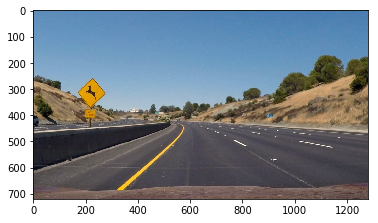

In [235]:
# Read in a test image
test_img = mpimg.imread('./test_images/test2.jpg')
plt.imshow(test_img)

# Camera Calibration

In a typical self driving car the eyes of the driver is replaced by cameras, cameras however don't record perfect videos and in most cases the video is strectched/distorted in some way which can affect out software from accurately observing the environment. To combat this we would like to apply techniques to undistort the image.

First the camera will be calculated using calibration images and then the resulting camera matrix and distortion coefficients will be used to undistort the image. 

## Calculate points for calibrating camera

Calculate the object points and image points used for calibrating the camera

In [62]:
# %matplotlib qt

cal_images = glob.glob('camera_cal/calibration*.jpg')

# Prepare object points like (0,0,0), (1, 0, 0), (2, 0, 0), ...., (8, 5, 0)
objp = np.zeros((6*9, 3), np.float32) # Initialize all to 0

# Use numpy's mgrid function to generate points https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.mgrid.html
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) # x, y coordinates only

def load_points(images):
    # Arrays to store object points and image points from all the images

    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image space
    for fname in images:
        # Read in image
        img = mpimg.imread(fname)

        # Convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
#             cv2.drawChessboardCorners(img, (9,6), corners, ret)
#             cv2.imshow('img', img)
#             cv2.waitKey(500)
    return objpoints, imgpoints
        
objpoints, imgpoints = load_points(cal_images)

## Function to Undistort image 

A function to undistort the image given the object points and image points calcaulated

In [63]:
def undistort_image(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])
    
    # Calibrate the camera 
    ret, camera_matrix, distortion_coefficients, rotation_vectors, translation_vectors = \
        cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    # Undistort the image
    undistorted_img = cv2.undistort(img, camera_matrix, distortion_coefficients, None, camera_matrix)
    
    return undistorted_img

undistorted = undistort_image(test_img, objpoints, imgpoints)

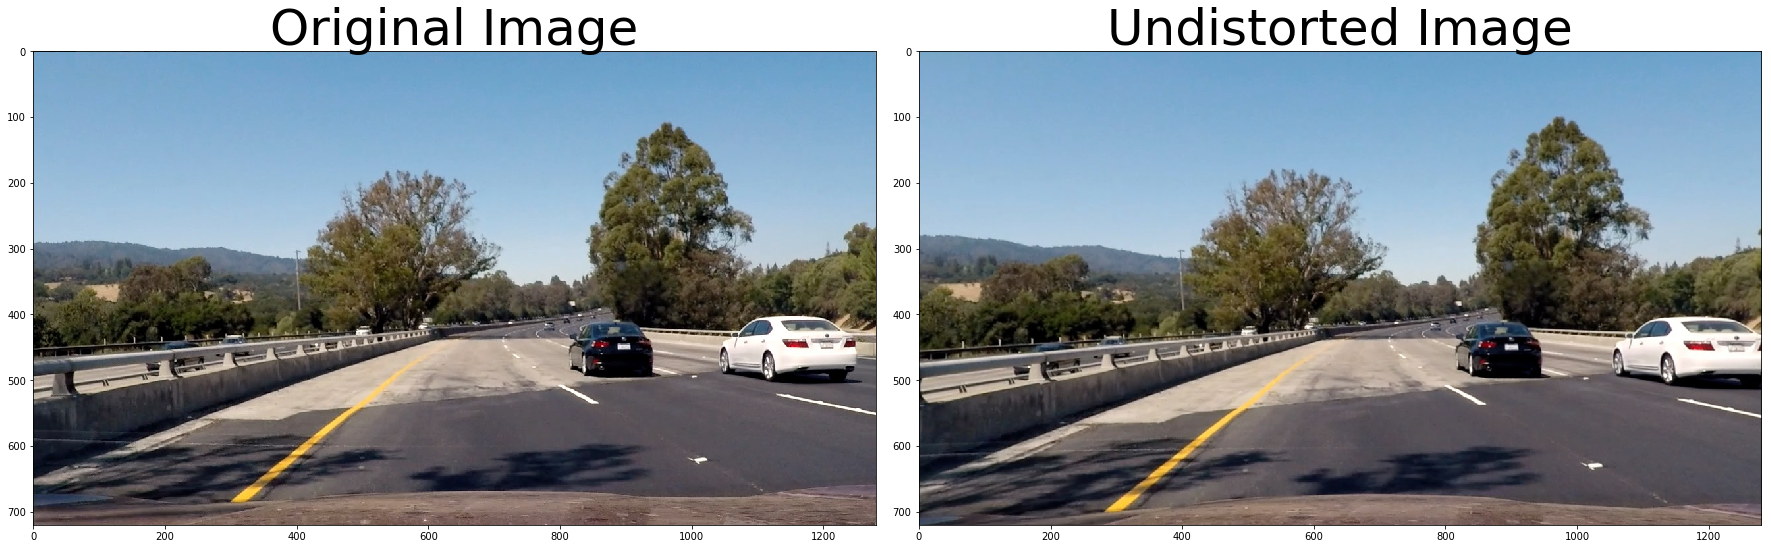

In [64]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Perspective Transform

Next we would like to apply a perspective transform to change the way we the application views the video. The goal is to properly detect the curvature of lane lines in the road and this is easier for the application to do if it were to have a top down view of the road. As such we will use a perspective transform to warp the image from its current viewpoint to a top down view.

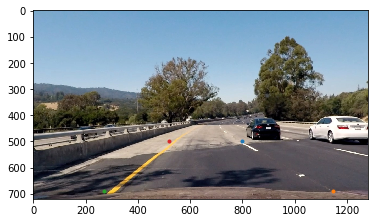

In [250]:
%matplotlib inline

plt.imshow(undistorted)
plt.plot(800, 500, '.') # Top right
plt.plot(1145, 690, '.') # Bottom right
plt.plot(270, 690, '.') # Bottom left
plt.plot(520, 500, '.') # Top left


In [303]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    
    # Four source coordinates
    src = np.float32(
        [[800, 500],
         [1145, 690],
         [270, 690],
         [520, 500]])
    
    dst = np.float32(
        [[900, 200],
         [900, 650],
         [200, 650],
         [200, 200]])
    
    M = cv2.getPerspectiveTransform(src, dst) # mapping as perspective matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, Minv

warped_img, Minv = warp(undistorted)

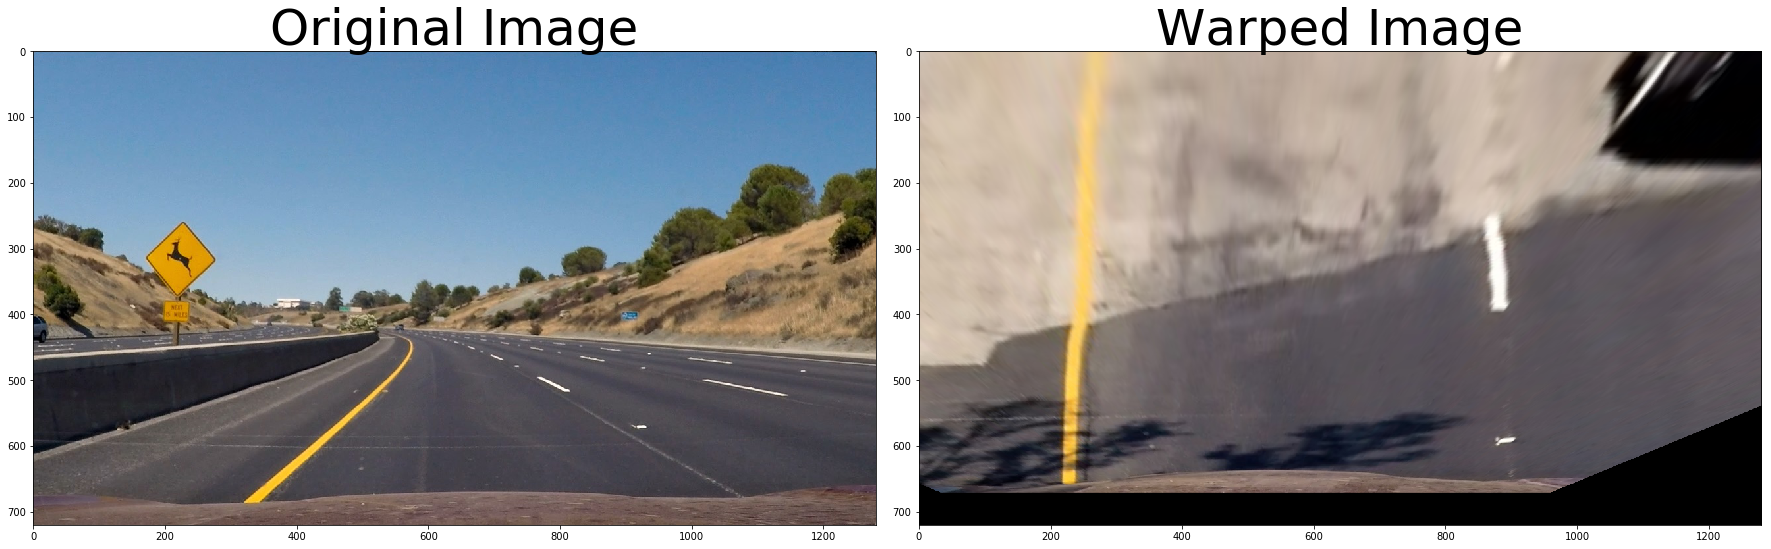

In [270]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_img)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Gradient thresholding

In order to focus on important information(lane lines) calculating the gradient of what the camera sees and bounding that within a threshold is definately a useful technique. Below Various forms of gradient thresholding functions are implemented and then combined in the effort to properly identify lane lines

In [232]:
ksize = 15

In [236]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

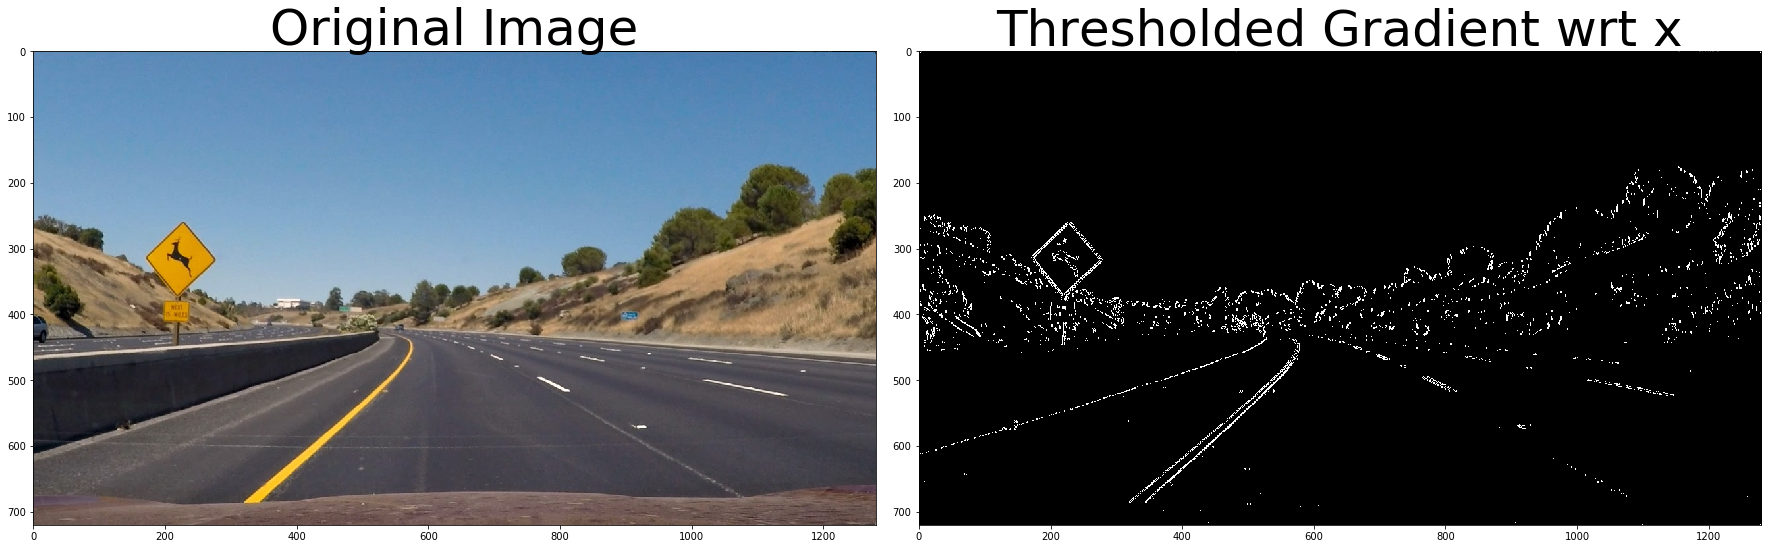

In [237]:
min_thresh_gradx, max_thresh_gradx = 40, 100

gradx = abs_sobel_thresh(test_img, orient='x', sobel_kernel=ksize, thresh_min=min_thresh_gradx, thresh_max=max_thresh_gradx)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(gradx, cmap='gray')
ax2.set_title('Thresholded Gradient wrt x', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

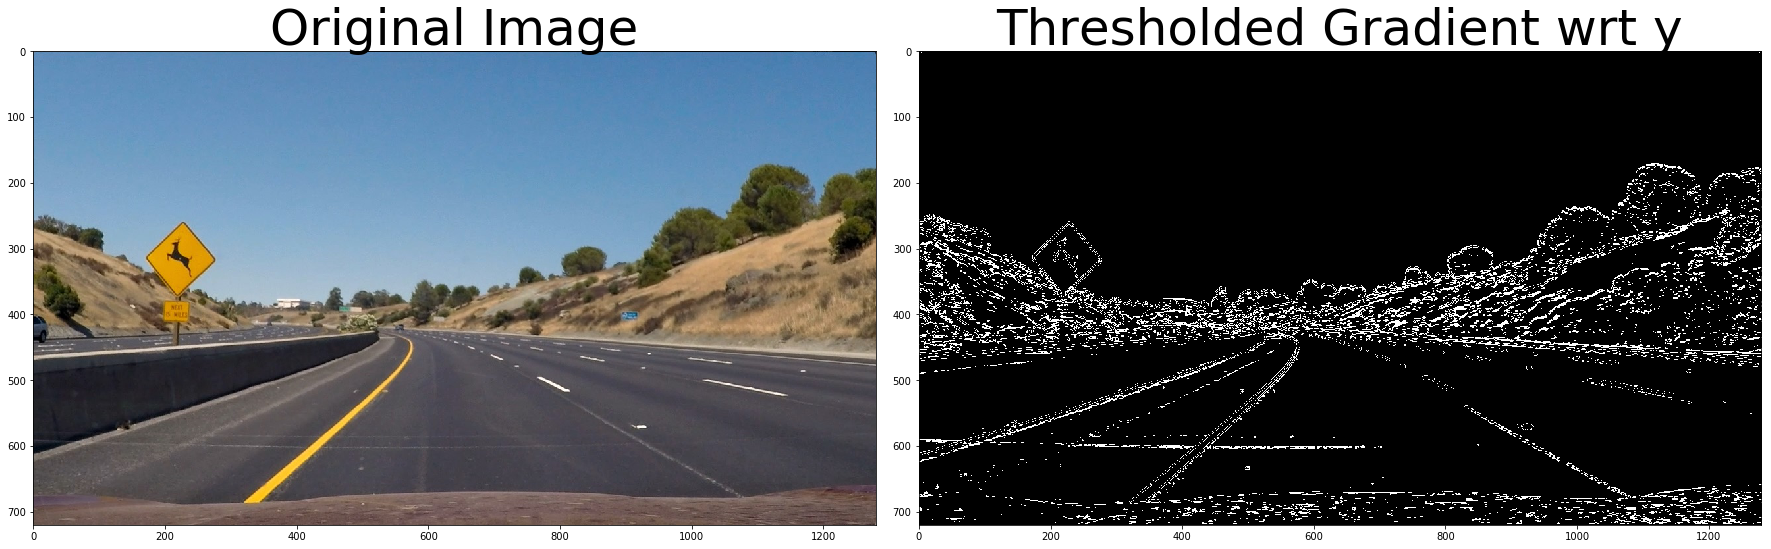

In [238]:
min_thresh_grady, max_thresh_grady = 20, 50
grady = abs_sobel_thresh(test_img, orient='y', sobel_kernel=ksize, thresh_min=min_thresh_grady, thresh_max=max_thresh_grady)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grady, cmap='gray')
ax2.set_title('Thresholded Gradient wrt y', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [239]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

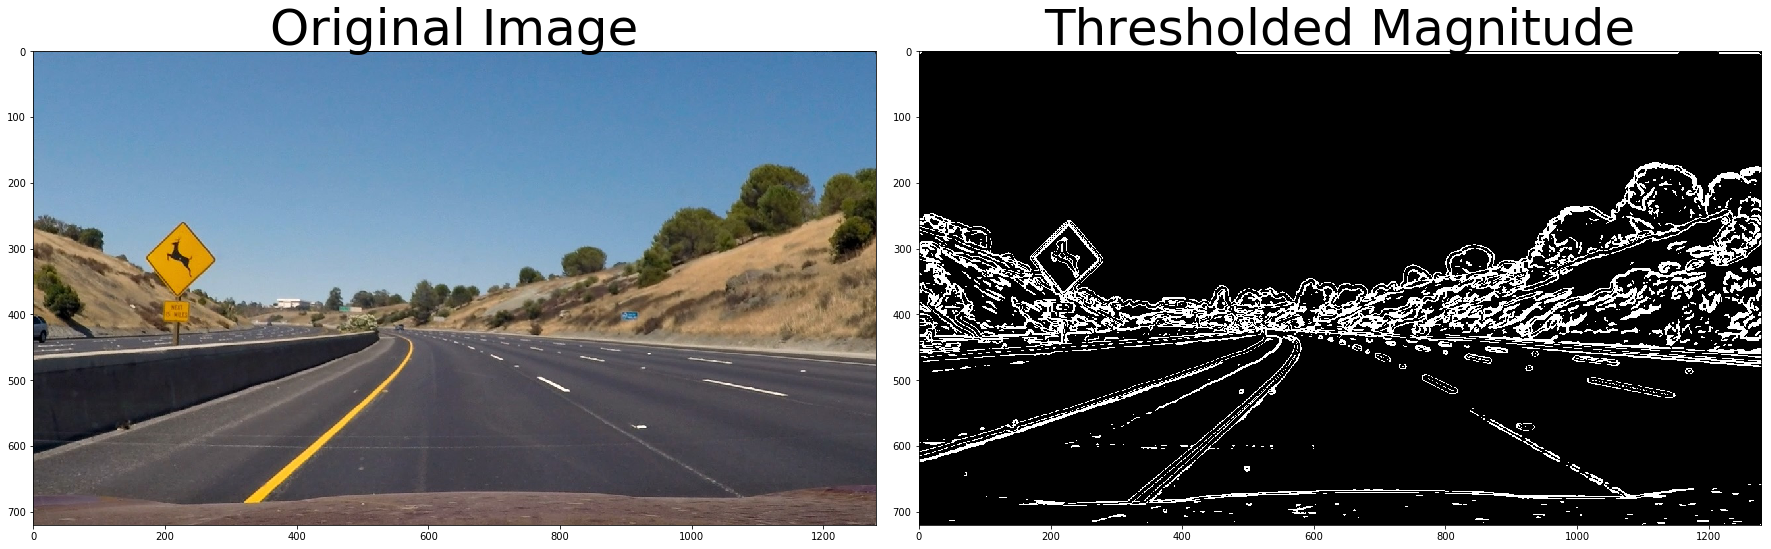

In [240]:
min_thresh_magnitude, max_thresh_magnitude = 30, 80
mag_binary = mag_thresh(test_img, sobel_kernel=ksize, mag_thresh=(min_thresh_magnitude, max_thresh_magnitude))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [241]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


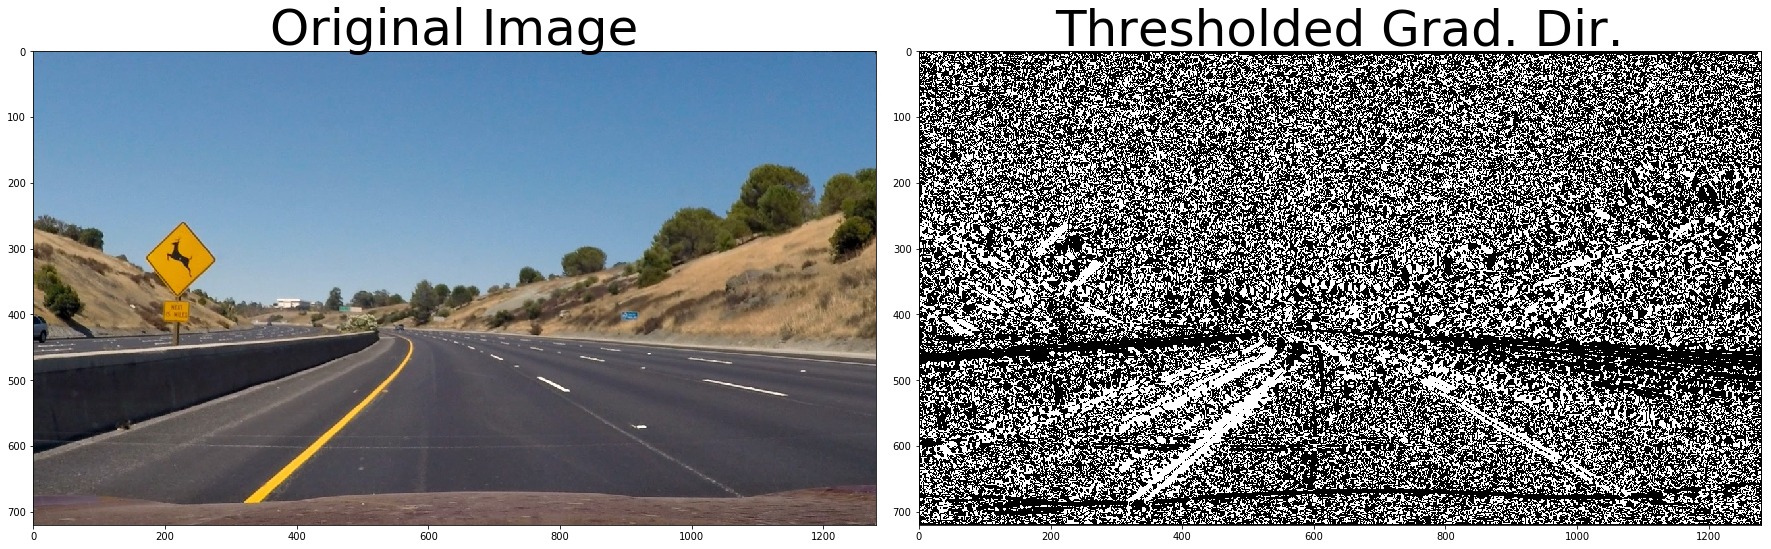

In [242]:
min_thresh_dir, max_thresh_dir = 0.7, 1.3
dir_binary = dir_threshold(test_img, sobel_kernel=ksize, thresh=(min_thresh_dir, max_thresh_dir))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

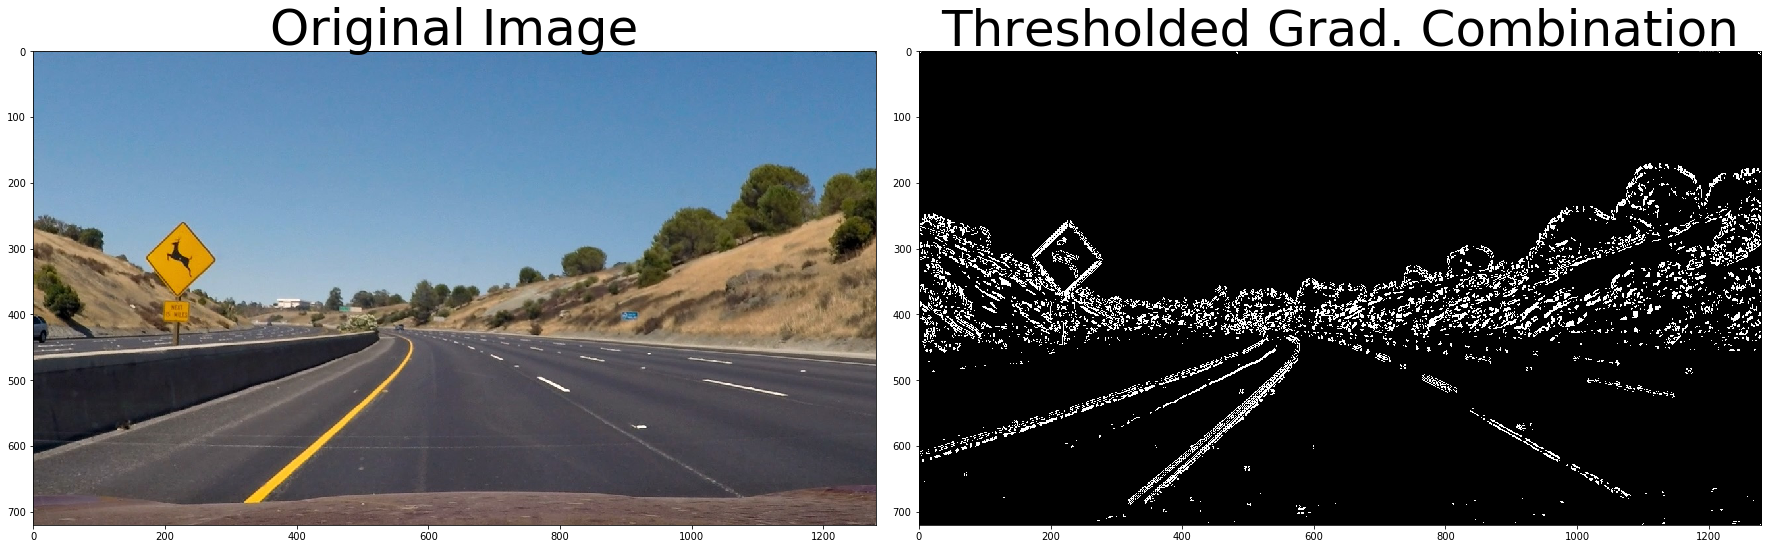

In [267]:
combined = np.zeros_like(dir_binary)
combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
# combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Combination', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Warp the image after thresholding applied

In [207]:
def apply_gradient_threshold(img):
    min_thresh_gradx, max_thresh_gradx = 40, 100
    min_thresh_grady, max_thresh_grady = 20, 50
    min_thresh_magnitude, max_thresh_magnitude = 30, 80
    min_thresh_dir, max_thresh_dir = 0.7, 1.3
    
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh_min=min_thresh_gradx, thresh_max=max_thresh_gradx)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh_min=min_thresh_grady, thresh_max=max_thresh_grady)
    
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(min_thresh_magnitude, max_thresh_magnitude))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(min_thresh_dir, max_thresh_dir))
    
    combined = np.zeros_like(dir_binary)
    # combined[(((gradx == 1) & (grady == 1)) | (mag_binary == 1)) & (dir_binary == 1)] = 1
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

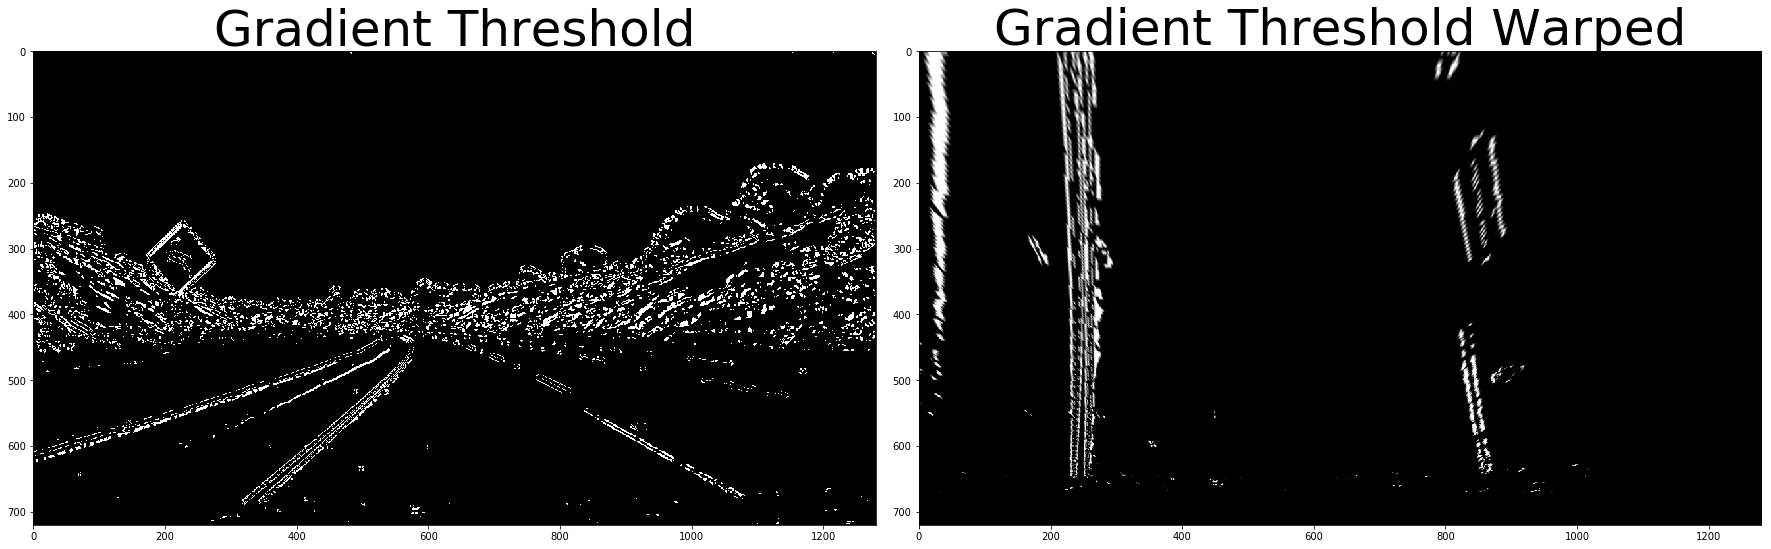

In [271]:
# Plot the result

gradient_threshold_img = apply_gradient_threshold(test_img)
gradient_threshold_img_warped = warp(gradient_threshold_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gradient_threshold_img, cmap='gray')
ax1.set_title('Gradient Threshold', fontsize=50)
ax2.imshow(gradient_threshold_img_warped, cmap='gray')
ax2.set_title('Gradient Threshold Warped', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Color Thresholding

In [147]:
# Convert the image to grayscale and apply a threshold that identfies lines
thresh = (180, 255)
gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

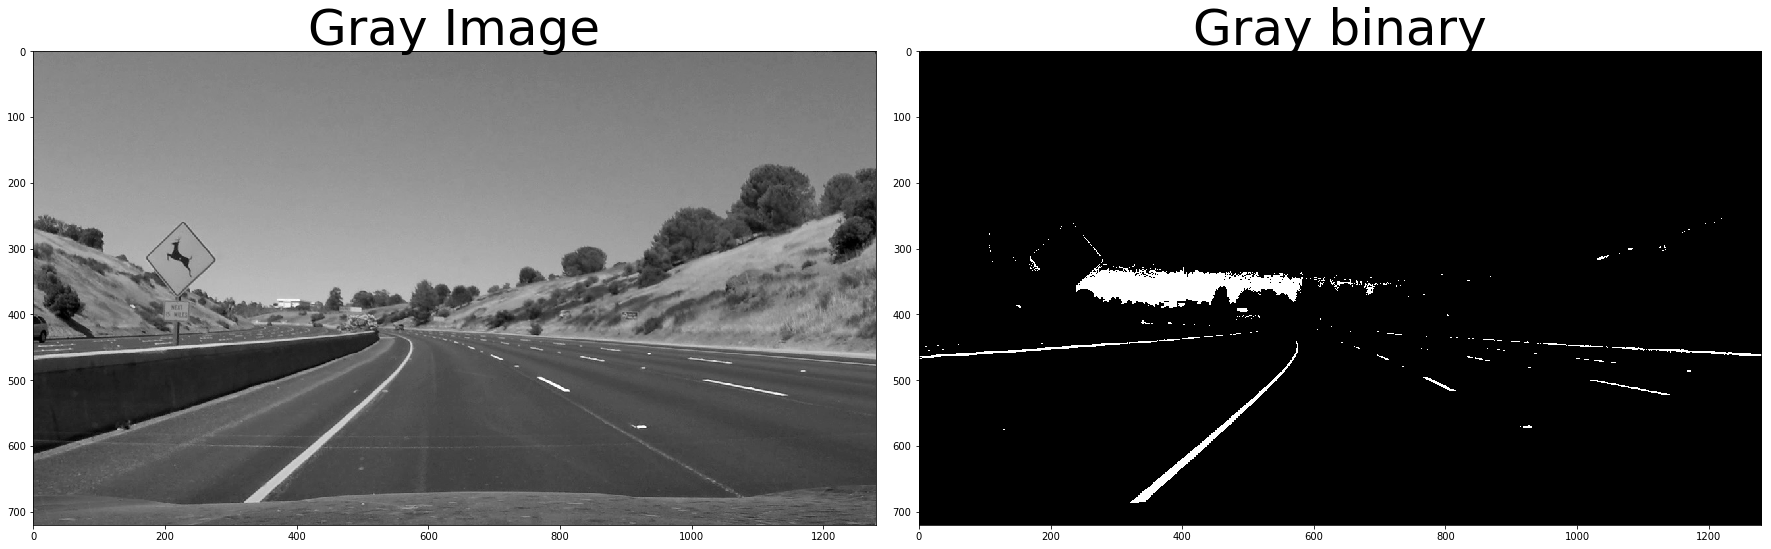

In [153]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gray, cmap='gray')
ax1.set_title('Gray Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Gray binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

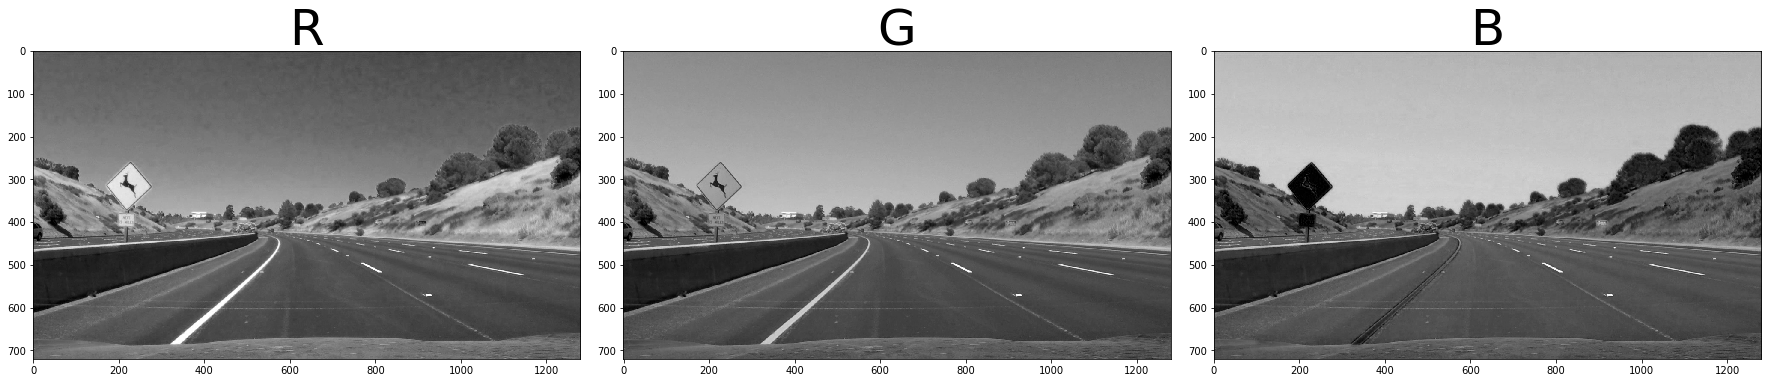

In [155]:
# Individual RGB values
R = test_img[:,:,0]
G = test_img[:,:,1]
B = test_img[:,:,2]

In [ ]:
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(R, cmap='gray')
ax1.set_title('R', fontsize=50)
ax2.imshow(G, cmap='gray')
ax2.set_title('G', fontsize=50)
ax3.imshow(B, cmap='gray')
ax3.set_title('B', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [158]:
# Apply a threshold to the individual channel
thresh = (200, 255)
binaryR = np.zeros_like(R)
binaryR[(R > thresh[0]) & (R <= thresh[1])] = 1

binaryG = np.zeros_like(G)
binaryG[(G > thresh[0]) & (G <= thresh[1])] = 1

binaryB = np.zeros_like(R)
binaryB[(B > thresh[0]) & (B <= thresh[1])] = 1

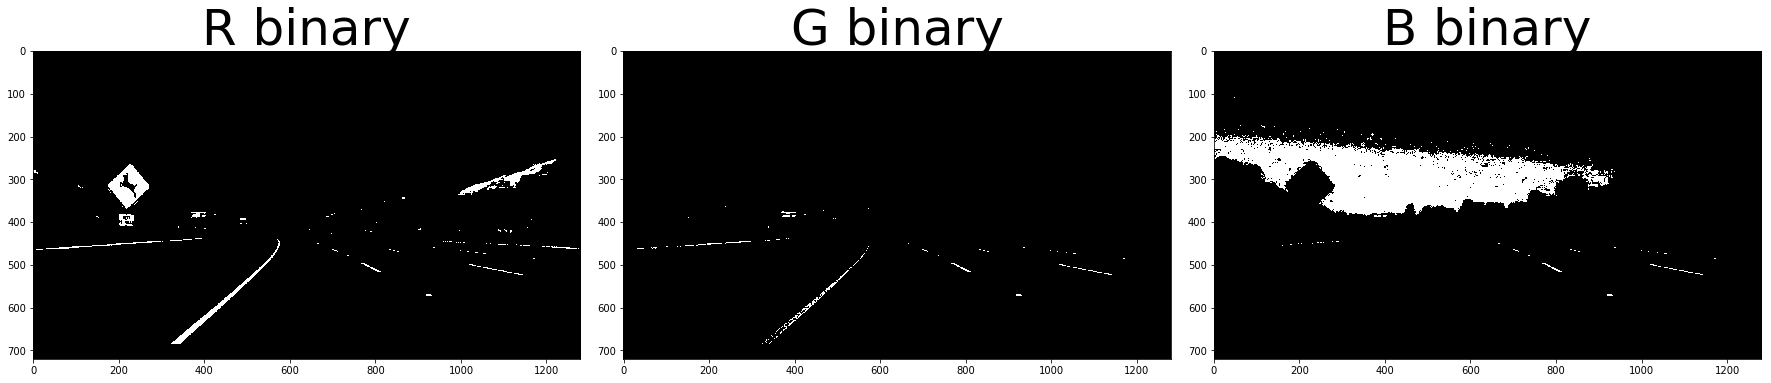

In [159]:
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binaryR, cmap='gray')
ax1.set_title('R binary', fontsize=50)
ax2.imshow(binaryG, cmap='gray')
ax2.set_title('G binary', fontsize=50)
ax3.imshow(binaryB, cmap='gray')
ax3.set_title('B binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### HLS Color Space

R channel seems to be doing a good job but I will be considering a separate color space that might lead to better results. 

In [188]:
# Individual HLS values
hls = cv2.cvtColor(test_img, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

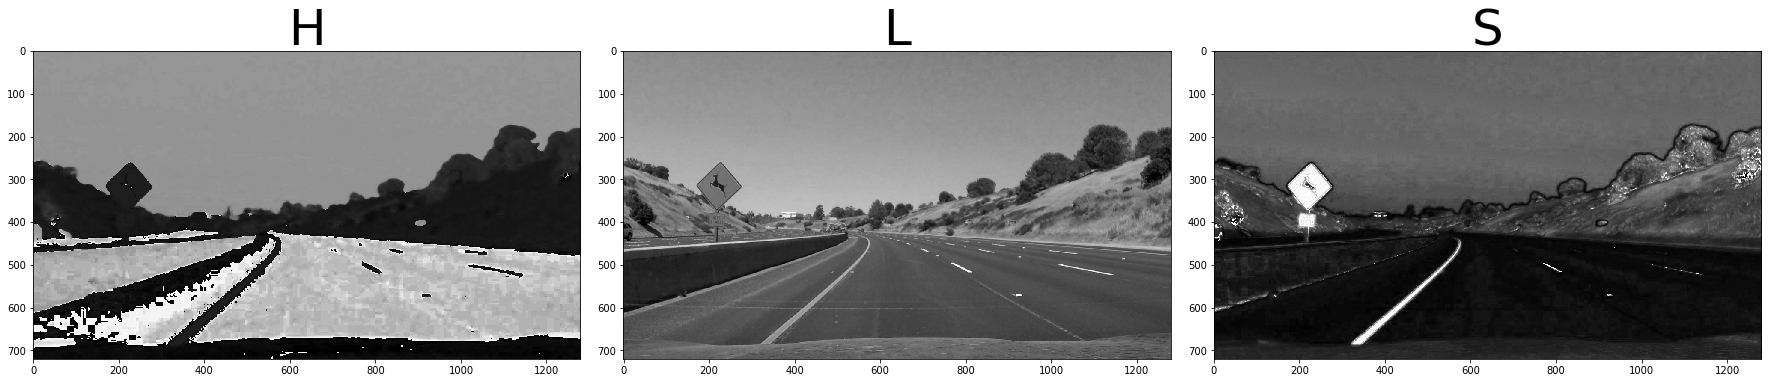

In [189]:
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(H, cmap='gray')
ax1.set_title('H', fontsize=50)
ax2.imshow(L, cmap='gray')
ax2.set_title('L', fontsize=50)
ax3.imshow(S, cmap='gray')
ax3.set_title('S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [190]:
# Apply a threshold to each individual channel
threshH = (15, 100)
binaryH = np.zeros_like(H)
binaryH[(H > threshH[0]) & (H <= threshH[1])] = 1

threshL = (140, 215)
binaryL = np.zeros_like(L)
binaryL[(L > threshL[0]) & (L <= threshL[1])] = 1

threshS = (90, 255)
binaryS = np.zeros_like(S)
binaryS[(S > threshS[0]) & (S <= threshS[1])] = 1

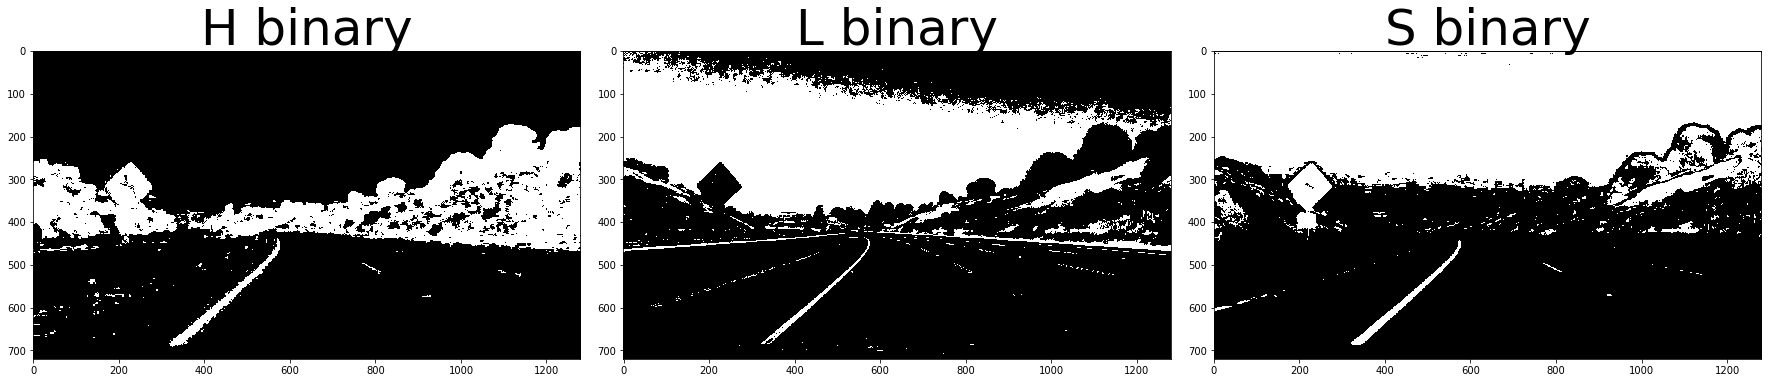

In [191]:
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binaryH, cmap='gray')
ax1.set_title('H binary', fontsize=50)
ax2.imshow(binaryL, cmap='gray')
ax2.set_title('L binary', fontsize=50)
ax3.imshow(binaryS, cmap='gray')
ax3.set_title('S binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

It seems the S channel is performing the best but not by much, it's a bit cleaner so will stick with HLS space and observe results. Let's combine the S channel threshold with the combined Gradient threshold see the result

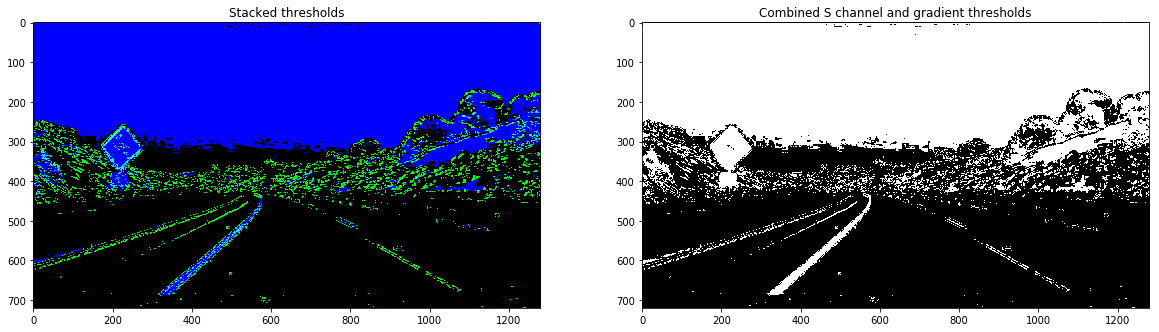

In [202]:
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(combined), combined, binaryS)).astype(np.uint8) *255

# Combine the two binary thresholds
combined_binary = np.zeros_like(combined)
combined_binary[(binaryS == 1) | (combined == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

In [272]:
def apply_color_threshold(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    # Apply a threshold to each individual channel
    threshH = (15, 100)
    binaryH = np.zeros_like(H)
    binaryH[(H > threshH[0]) & (H <= threshH[1])] = 1

    threshL = (140, 215)
    binaryL = np.zeros_like(L)
    binaryL[(L > threshL[0]) & (L <= threshL[1])] = 1

    threshS = (90, 255)
    binaryS = np.zeros_like(S)
    binaryS[(S > threshS[0]) & (S <= threshS[1])] = 1
    return binaryS


In [273]:
def combine(gradient_threshold, color_threshold):
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(gradient_threshold)
    combined_binary[(color_threshold == 1) | (gradient_threshold == 1)] = 1
    return combined_binary

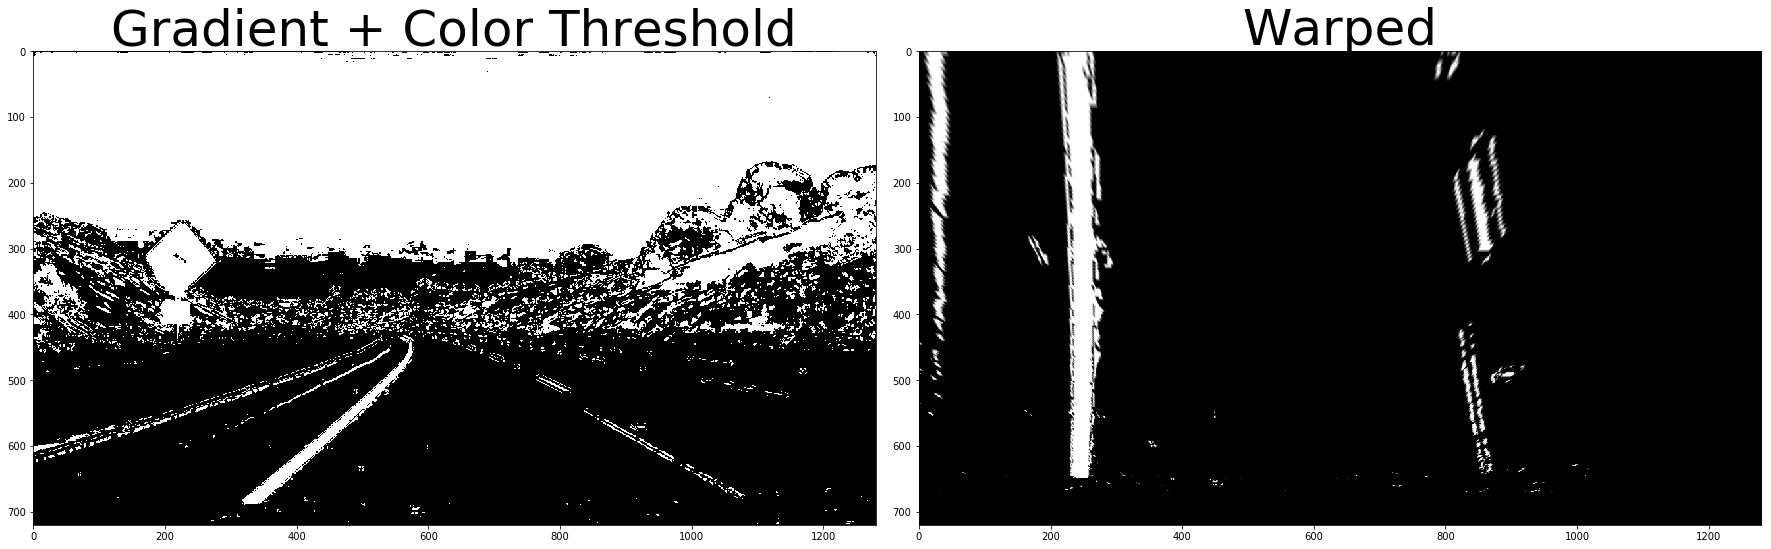

In [279]:
color_threshold_img = apply_color_threshold(test_img)
combined_thresholds = combine(gradient_threshold_img, color_threshold_img)
binary_warped = warp(combined_thresholds)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_thresholds, cmap='gray')
ax1.set_title('Gradient + Color Threshold', fontsize=50)
ax2.imshow(combined_thresholds_img_warped, cmap='gray')
ax2.set_title('Warped', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

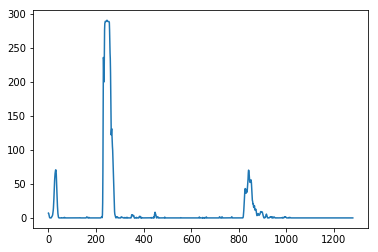

In [280]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [281]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

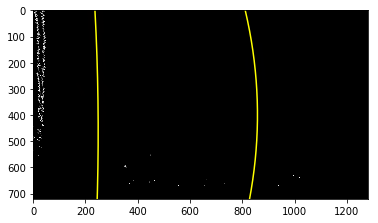

In [295]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
# Plot up the fake data
mark_size = 3
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [283]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

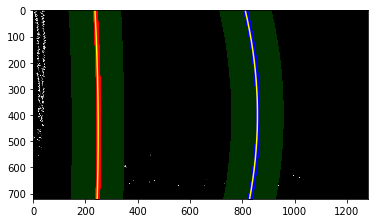

In [296]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

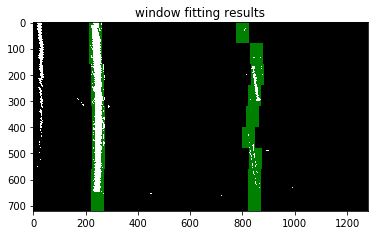

In [298]:
# Read in a thresholded image
warped = binary_warped
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped)).astype(np.uint8)*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

In [299]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

8705.2878966 1797.79518674


In [301]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

2855.64045797 m 561.17068212 m


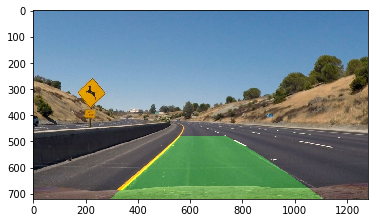

In [305]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (test_img.shape[1], test_img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(test_img, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [ ]:
def pipeline(image):
    return None

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    return pipeline(image)

In [ ]:
video_output = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)